Here I am using an ensemble method with the combination of **NB-SVM** baseline model and the LSTM model

## NB-SVM Model

In [0]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import io
import matplotlib as plt
from sklearn.model_selection import cross_val_score

Importing Files from local to Google Colab

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving test_labels.csv to test_labels.csv
Saving train.csv to train.csv


In [0]:
train=pd.read_csv(io.BytesIO(uploaded['train.csv']))
test=pd.read_csv(io.BytesIO(uploaded['test.csv']))
subm=pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))
test_labels=pd.read_csv('test_labels.csv')

#Looking at the Data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [4]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


The length of comment varies a lot

In [6]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

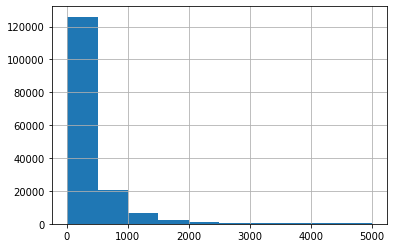

In [7]:
lens.hist()

Most of the comments lie between 0-1000 size length

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [8]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[labels].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that the dataset looks balanced

In [9]:
len(train),len(test)

(159571, 153164)

In [10]:
train.isnull().sum(axis=0)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
none             0
dtype: int64

Since there are no NULL values we need not set values

# Buliding the Model

We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [0]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

We use TF-IDF

In [0]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
train_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

In [13]:
train_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

Navie Bayes feature Extraction

In [0]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [0]:
x = train_term_doc
test_x = test_term_doc

Fit a model one dependent at a time

In [0]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=False)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [17]:
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [18]:
import warnings
warnings.filterwarnings('ignore')
preds = np.zeros((len(test), len(labels)))

for i, j in enumerate(labels):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [19]:
preds

array([[9.99987679e-01, 1.09154131e-01, 9.99987295e-01, 2.33988849e-03,
        9.62474045e-01, 9.51723454e-02],
       [2.82989151e-03, 5.87428825e-04, 1.86115135e-03, 8.87962734e-05,
        2.21521436e-03, 3.30644095e-04],
       [1.17593301e-02, 8.42350096e-04, 5.54908986e-03, 9.04142202e-05,
        3.19115572e-03, 2.87817114e-04],
       ...,
       [1.37616560e-03, 1.54317536e-04, 2.65625841e-03, 7.03447088e-05,
        9.37527477e-04, 1.86825842e-04],
       [8.01977683e-03, 3.28158768e-04, 2.24673613e-03, 8.66010098e-05,
        2.19951809e-03, 8.58965899e-04],
       [9.45071422e-01, 1.13486460e-04, 4.24275383e-01, 3.19035022e-04,
        4.44254625e-02, 7.94593208e-04]])

Creating the submission file

In [0]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = labels)], axis=1)
submission.to_csv('submission.csv', index=False)

# LSTM

Here we attempt to tackle this classification problem by using Keras LSTM. 
We import the standard Keras library:

In [22]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


Loading the train and test files, we have already loaded the file as train and test

Since we have already checked that there are no null values, so we need not deal with it.

the dependent variables are in the training set itself so we need to split them up, into X and Y sets.

In [23]:
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [0]:
y = train[labels].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

**The approach:** we need to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:



1.   **Tokenization** - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2.   **Indexing** - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. **Index Representation** - We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]





In Keras, all the above steps can be done in 4 lines of code. Note that we have to define the number of unique words in our dictionary when tokenizing the sentences.

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

To look up the occurences and index of each word in the dictionary

In [0]:
#commented it due to long output
#for occurence of words:
#tokenizer.word_counts
#for index of words:
#tokenizer.word_index

Now, if you look at "list_tokenized_train", you will see that Keras has turned our words into index representation for us

In [27]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

There's another problem! What if some comments are terribly long, while some are just 1 word? Wouldn't our indexed-sentence look like this:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

And we have to feed a stream of data that has a consistent length(fixed number of features) isn't it?

And this is why we use "padding"! We could make the shorter sentences as long as the others by filling the shortfall by zeros.But on the other hand, we also have to trim the longer ones to the same length(maxlen) as the short ones. In this case, we have set the max length to be 200.

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

How do you know what is the best "maxlen" to set? If you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.

One of the ways to go about it is to see the distribution of the number of words in sentences.

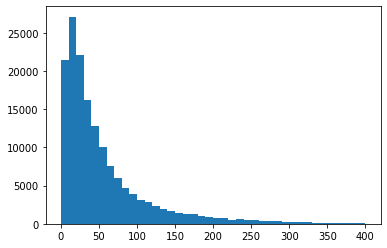

In [29]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50, but I'm being paranoid so I have set to 200. 

# Building the Model

This is the architecture of the model we are trying to build. It's always to good idea to list out the dimensions of each layer in the model to think visually and help you to debug later on.
![alt text](https://i.imgur.com/txJomEa.png)

As mentioned earlier, the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200. 

![alt text](https://i.imgur.com/uSjU4J7.png)

By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [0]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence.The output of the Embedding layer is just a list of the coordinates of the words in this vector space. For eg. (-81.012) for "cat" and (-80.012) for "dog". We could also use the distance of these coordinates to detect relevance and context. Embedding is a pretty deep topic, and if you are interested, this is a comprehensive guide: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

We need to define the size of the "vector space" we have mentioned above, and the number of unique words(max_features) we are using. Again, the embedding size is a parameter that you can tune and experiment.

In [0]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results. As you probably know, LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

From the above picture, the unrolled LSTM would give us a set of h0,h1,h2 until the last h.

From the short line of code that defines the LSTM layer, it's easy to miss the required input dimensions. LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

We can make use of the output from the previous embedding layer which outputs a 3-D tensor of (None, 200, 128) into the LSTM layer. What it does is going through the samples, recursively run the LSTM model for 200 times, passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 200, 60), where 60 is the output dimension we have defined.

In [0]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

As you can see from other Kaggle kernels, different variants (Average,Max,etc) of pooling layers are used for dimensionality reduction and they could yield different results so do try them out.

If you are interested in finding out the technical details of pooling, read up here: https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/

In [0]:
x = GlobalMaxPool1D()(x)

With a 2D Tensor in our hands, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/dropout.jpeg)

We set the dropout layer to drop out 10%(0.1) of the nodes.

In [0]:
x = Dropout(0.1)(x)

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:

Activation( (Input X Weights) + Bias)

all in 1 line, with the weights, bias and activation layer all set up for you! We have defined the Dense layer to produce a output dimension of 50.



In [0]:
x = Dense(50, activation="relu")(x)

We feed the output into a Dropout layer again.

In [0]:
x = Dropout(0.1)(x)

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.

In [0]:
x = Dense(6, activation="sigmoid")(x)

We are almost done! All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification. In case you are looking for the learning rate, the default is set at 0.001.

In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs. These are some of the tunable parameters that you can experiment with, to see if you can push the accurate to the next level without crashing your machine(hence the batch size).

In [39]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 537s 4ms/step - loss: 0.0678 - accuracy: 0.9779 - val_loss: 0.0498 - val_accuracy: 0.9815
Epoch 2/2
143613/143613 [==============================] - 532s 4ms/step - loss: 0.0455 - accuracy: 0.9829 - val_loss: 0.0468 - val_accuracy: 0.9826


the accuracy is pretty decent, furthermore we can adjust the parameters

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [0]:
pred_lstm=model.predict(X_te)

In [42]:
pred_lstm

array([[9.9672180e-01, 4.3262917e-01, 9.5578039e-01, 1.3816160e-01,
        9.0893239e-01, 2.6962963e-01],
       [1.4660954e-03, 2.3065004e-06, 8.0007696e-05, 3.8518683e-06,
        1.2442470e-04, 2.7977556e-05],
       [2.7725697e-03, 1.0901669e-05, 1.9001961e-04, 1.5692594e-05,
        3.3110380e-04, 8.2377388e-05],
       ...,
       [1.1059642e-03, 8.2784788e-07, 4.9463000e-05, 1.6336829e-06,
        6.7029723e-05, 1.4768184e-05],
       [2.7576089e-03, 1.5146145e-06, 9.1697962e-05, 4.3720834e-06,
        1.3509393e-04, 3.1187596e-05],
       [9.6741378e-01, 3.8724333e-02, 7.8003013e-01, 1.0074019e-02,
        6.4236188e-01, 3.9511949e-02]], dtype=float32)

Creating the submission file for LSTM

In [0]:
submid2 = pd.DataFrame({'id': subm["id"]})
submission2 = pd.concat([submid2, pd.DataFrame(preds, columns = labels)], axis=1)
submission2.to_csv('submission2.csv', index=False)

# Applying the Ensemble 

In theory, an ensemble works best when the individual models are as different as possible. Therefore, we should see that even a simple average of these two models gets a good result.

In [0]:
res_lstm = pd.read_csv('submission2.csv')
res_nbsvm = pd.read_csv('submission.csv')

In [0]:
res_final = res_lstm.copy()
res_final[labels] = (res_nbsvm[labels] + res_lstm[labels]) / 2

Now we create the final result csv file

In [0]:
res_final.to_csv('submission_final.csv', index=False)

In [0]:
files.download('submission_final.csv')

**The stated method gives an accuracy of 0.9778 on Kaggle.**